In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import pickle
import gc

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import lightgbm as lgb

In [3]:
df = pd.read_csv('train.csv')
df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


## ベースライン作成

### データセットの作成

In [4]:
x_train, y_train, id_train = df[['Pclass', 'Fare']], df[['Survived']], df[['PassengerId']]

### ベースライン検証用データの作成

In [5]:
# ベースライン検証用データ(x_va, y_va)の作成
x_tr, x_va, y_tr, y_va = train_test_split(x_train, y_train,
                                           test_size=0.2,
                                           shuffle=True,
                                           stratify=y_train,
                                           random_state=123)

### クロスバリデーション(5-fold)

In [7]:
# x_tr.loc[] 　ERROR:'Passing list-likes to .loc or [] with any missing labels is no longer supported
# -> 存在しないキーに対して.locで参照しようとしているためエラーが発生。x_trはベースライン検証データを分割した際に欠損ができている。
# indexを更新したら解決するか
x_tr = x_tr.reset_index(drop=True)
y_tr = y_tr.reset_index(drop=True)

In [40]:
# ハイパーパラメータ
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc', 
    'learning_rate': 0.1,
    'num_leaves': 16,
    'n_estimators': 100000,
    'random_state': 123,
    'importance_type': 'gain',
}

metrics = []
imp = pd.DataFrame()


n_splits = 5
# x_tr, y_trのデータセットの分割の組み合わせをn_splits種類作成、それぞれのindexをリストで所持
cv = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123).split(x_tr, y_tr))

# クロスバリデーション
for nfold in np.arange(n_splits):
    print('-'*20, nfold, '-'*20)
    # 学習データ(x_tr1,y_tr1)と検証データ(x_va1,y_va1)の分割
    idx_tr, idx_va = cv[nfold][0], cv[nfold][1] # 各組合わせcv[tr],cv[va]のidxを格納
    x_tr1, y_tr1 = x_tr.loc[idx_tr], y_tr.loc[idx_tr] # trindex -> 学習用データフレイム作成
    x_va1, y_va1 = x_tr.loc[idx_va], y_tr.loc[idx_va] # vaindex -> 検証用データフレイム作成
    print(x_tr1.shape, y_tr1.shape) # 学習データ
    print(x_va1.shape, y_va1.shape) # 検証データ
    print('y_tr:{:.3f}, y_tr1:{:.3f}, y_va1:{:.3f}'.format(y_tr['Survived'].mean(),
                                               y_tr1['Survived'].mean(),
                                               y_va1['Survived'].mean(),
                                               ))
    
    # モデル学習
    model = lgb.LGBMClassifier()
    model.fit(x_tr1, y_tr1,
              eval_set = [(x_tr1, y_tr1), (x_va1, y_va1)],
              callbacks=[lgb.early_stopping(stopping_rounds=100,
                                            verbose=10)
                         ])
    
    # 精度評価
    y_va1_pred = model.predict(x_va1) 
    y_va_pred = model.predict(x_va)    
    metric_va1 = accuracy_score(y_va1, y_va1_pred) # 検証用データ
    metric_va = accuracy_score(y_va, y_va_pred) # ベースライン検証用データ
    print(f'[検証用データ]acc:{metric_va1:.4f}')
    print(f'[ベースライン検証用データ]acc:{metric_va:.4f}')
    
    metrics.append([nfold, metric_va1, metric_va])
    _imp = pd.DataFrame({'col': x_tr.columns,
                         'imp':model.feature_importances_,
                         'nfold': nfold})
    imp = pd.concat([imp, _imp], axis=0, ignore_index=True)

-------------------- 0 --------------------
(569, 2) (569, 1)
(143, 2) (143, 1)
y_tr:0.383, y_tr1:0.383, y_va1:0.385
[1]	training's binary_logloss: 0.644244	valid_1's binary_logloss: 0.654045
Training until validation scores don't improve for 100 rounds
[2]	training's binary_logloss: 0.626498	valid_1's binary_logloss: 0.64288
[3]	training's binary_logloss: 0.612086	valid_1's binary_logloss: 0.636296
[4]	training's binary_logloss: 0.599696	valid_1's binary_logloss: 0.628585
[5]	training's binary_logloss: 0.589674	valid_1's binary_logloss: 0.624997
[6]	training's binary_logloss: 0.581299	valid_1's binary_logloss: 0.622469
[7]	training's binary_logloss: 0.573875	valid_1's binary_logloss: 0.618863
[8]	training's binary_logloss: 0.567687	valid_1's binary_logloss: 0.617064
[9]	training's binary_logloss: 0.562518	valid_1's binary_logloss: 0.615393
[10]	training's binary_logloss: 0.557819	valid_1's binary_logloss: 0.613938
[11]	training's binary_logloss: 0.551979	valid_1's binary_logloss: 0.61

/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[検証用データ]acc:0.6923
[ベースライン検証用データ]acc:0.6872
-------------------- 1 --------------------
(569, 2) (569, 1)
(143, 2) (143, 1)
y_tr:0.383, y_tr1:0.383, y_va1:0.385
[1]	training's binary_logloss: 0.647608	valid_1's binary_logloss: 0.648855
Training until validation scores don't improve for 100 rounds
[2]	training's binary_logloss: 0.633028	valid_1's binary_logloss: 0.634824
[3]	training's binary_logloss: 0.620704	valid_1's binary_logloss: 0.623418
[4]	training's binary_logloss: 0.610587	valid_1's binary_logloss: 0.613914
[5]	training's binary_logloss: 0.601796	valid_1's binary_logloss: 0.605919
[6]	training's binary_logloss: 0.594681	valid_1's binary_logloss: 0.599199
[7]	training's binary_logloss: 0.588585	valid_1's binary_logloss: 0.593092
[8]	training's binary_logloss: 0.583514	valid_1's binary_logloss: 0.588526
[9]	training's binary_logloss: 0.578301	valid_1's binary_logloss: 0.584517
[10]	training's binary_logloss: 0.574138	valid_1's binary_logloss: 0.581237
[11]	training's binary_log

/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (


[52]	training's binary_logloss: 0.495285	valid_1's binary_logloss: 0.588423
[53]	training's binary_logloss: 0.4946	valid_1's binary_logloss: 0.58802
[54]	training's binary_logloss: 0.493947	valid_1's binary_logloss: 0.588625
[55]	training's binary_logloss: 0.493347	valid_1's binary_logloss: 0.588102
[56]	training's binary_logloss: 0.492778	valid_1's binary_logloss: 0.587837
[57]	training's binary_logloss: 0.492248	valid_1's binary_logloss: 0.587451
[58]	training's binary_logloss: 0.491688	valid_1's binary_logloss: 0.587049
[59]	training's binary_logloss: 0.491135	valid_1's binary_logloss: 0.587581
[60]	training's binary_logloss: 0.490715	valid_1's binary_logloss: 0.588052
[61]	training's binary_logloss: 0.490065	valid_1's binary_logloss: 0.587272
[62]	training's binary_logloss: 0.489563	valid_1's binary_logloss: 0.58743
[63]	training's binary_logloss: 0.489142	valid_1's binary_logloss: 0.588337
[64]	training's binary_logloss: 0.488592	valid_1's binary_logloss: 0.587724
[65]	training's

/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (


[50]	training's binary_logloss: 0.490393	valid_1's binary_logloss: 0.617723
[51]	training's binary_logloss: 0.489763	valid_1's binary_logloss: 0.617806
[52]	training's binary_logloss: 0.488993	valid_1's binary_logloss: 0.616269
[53]	training's binary_logloss: 0.488363	valid_1's binary_logloss: 0.616712
[54]	training's binary_logloss: 0.487624	valid_1's binary_logloss: 0.615949
[55]	training's binary_logloss: 0.487047	valid_1's binary_logloss: 0.61701
[56]	training's binary_logloss: 0.48646	valid_1's binary_logloss: 0.616898
[57]	training's binary_logloss: 0.48592	valid_1's binary_logloss: 0.617698
[58]	training's binary_logloss: 0.485446	valid_1's binary_logloss: 0.617363
[59]	training's binary_logloss: 0.484921	valid_1's binary_logloss: 0.618091
[60]	training's binary_logloss: 0.484252	valid_1's binary_logloss: 0.617257
[61]	training's binary_logloss: 0.483763	valid_1's binary_logloss: 0.616447
[62]	training's binary_logloss: 0.4832	valid_1's binary_logloss: 0.615854
[63]	training's 

### 精度評価

In [ ]:
print('-'*20, 'result', '-'*20)
metrics = np.array(metrics)
print(metrics)

print('[cv]検証用データ: {:.3f}+-{:.3f}, ベースライン検証用データ: {:.3f}+-{:.3f}'.format(
    metrics[:, 1].mean(), metrics[:, 1].std(),
    metrics[:, 2].mean(), metrics[:, 2].std(),
))

imp = imp.groupby('col')['imp'].agg(['mean', 'std'])
imp.columns = ['imp', 'imp_std']
imp = imp.reset_index(drop=False)

print('Done')

In [17]:
# 説明変数の重要度算出
imp.sort_values('imp', ascending=False, ignore_index=True)

,col,imp,imp_std
0,Fare,1776.0,19.697716
1,Pclass,115.8,12.872451


In [28]:
# 誤差分布
print('検証用データ')
print(confusion_matrix(y_va1, y_va1_pred))
print(confusion_matrix(y_va1, y_va1_pred,  normalize='all')) # 全データを分母とした割合
print('ベースライン検証用データ')
print(confusion_matrix(y_va, y_va_pred))
print(confusion_matrix(y_va, y_va_pred,  normalize='all'))

検証用データ
[[75 12]
 [30 25]]
[[0.52816901 0.08450704]
 [0.21126761 0.17605634]]
ベースライン検証用データ
[[87 23]
 [29 40]]
[[0.48603352 0.12849162]
 [0.16201117 0.22346369]]


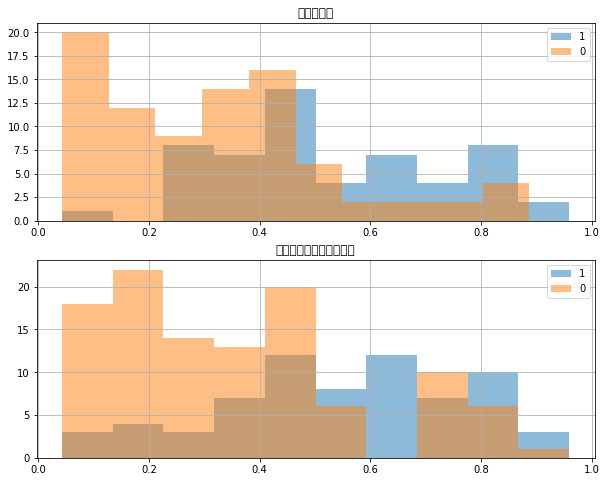

In [39]:
# 予測値の分布比較
y_va1_pred_prod = model.predict_proba(x_va1)[:, 1]
y_va_pred_prod = model.predict_proba(x_va)[:, 1]

fig = plt.figure(figsize=(10, 8))

fig.add_subplot(2, 1, 1)
plt.title('検証データ')
plt.hist(y_va1_pred_prod[np.array(y_va1).reshape(-1)==1], bins=10, alpha=0.5, label='1')
plt.hist(y_va1_pred_prod[np.array(y_va1).reshape(-1)==0], bins=10, alpha=0.5, label='0')
plt.grid()
plt.legend()

fig.add_subplot(2, 1, 2)
plt.title('ベースライン検証データ')
plt.hist(y_va_pred_prod[np.array(y_va).reshape(-1)==1], bins=10, alpha=0.5, label='1')
plt.hist(y_va_pred_prod[np.array(y_va).reshape(-1)==0], bins=10, alpha=0.5, label='0')
plt.grid()
plt.legend()

### モデル推論

In [41]:
df_test = pd.read_csv('test.csv')
x_test = df_test[['Pclass', 'Fare']]
id_test = df_test[['PassengerId']]
y_test_pred = model.predict(x_test)
df_submit = pd.DataFrame({
    'PassengerId': id_test['PassengerId'],
    'Survived': y_test_pred
})
df_submit

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [42]:
df_submit.to_csv('c_submission_baseline.csv', index=None)